In [1]:
import numpy as np
from scipy import constants 
import scipy

#visuals
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
matplotlib.rcParams.update({'font.size': 10})

#Interactive
from ipywidgets.widgets import * 
import ipywidgets as widgets

#Hugo code
import Utility
import PythonKEX 

In [2]:
image_shape = (Utility.SEGMENT_TABLE[0],Utility.NUMBER_OF_PROJECTIONS//2, Utility.NUMBER_OF_PROJECTIONS//2)
dim_titles = ['z bin gantry-bed', 'y bin up-down', 'x bin left-right']

In [3]:
#test with listmode data and kanyl
print(PythonKEX.define_KEX_dataset.__doc__)
LM_paths, sino_paths, phantom_str, recon_paths = PythonKEX.define_KEX_dataset(isKanyl=False,TOF=True, recon_str="OP")

 return list mode paths, sinograms paths, phantom title (Cannula or Cylinder ), and paths to reconstructions 


C:\Users\petct\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


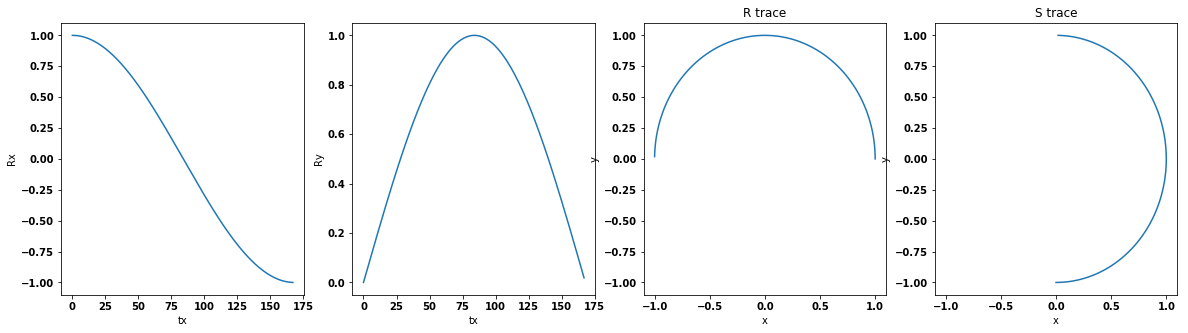

In [4]:
%matplotlib inline
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)
plt.plot(np.arange(Utility.NUMBER_OF_VIEWS), Utility.TX_ANGLE_TO_RX[:])
plt.ylabel('Rx')
plt.xlabel("tx")
plt.subplot(1,4,2)
plt.plot(np.arange(Utility.NUMBER_OF_VIEWS), Utility.TX_ANGLE_TO_RY[:])
plt.ylabel('Ry')
plt.xlabel("tx")
plt.subplot(1,4,3)
plt.plot(Utility.TX_ANGLE_TO_RX, Utility.TX_ANGLE_TO_RY)
plt.plot(0, -1)
plt.title('R trace')
plt.xlabel('x')
plt.ylabel("y")
plt.subplot(1,4,4)
plt.plot(Utility.TX_ANGLE_TO_RY, -1*Utility.TX_ANGLE_TO_RX)
plt.plot(0-1, 0)
plt.title('S trace')
plt.xlabel('x')
plt.ylabel("y")
plt.show()

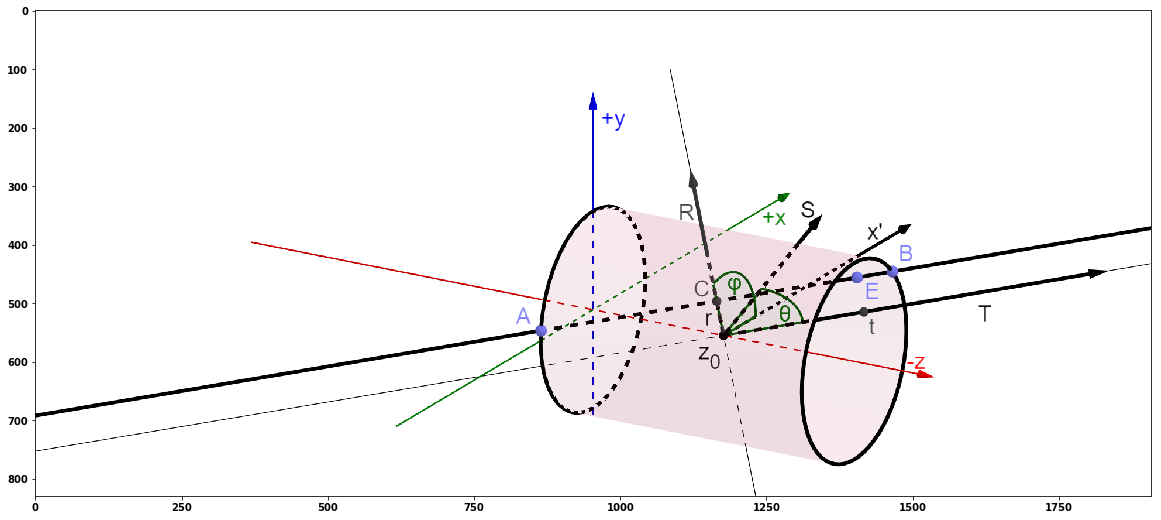

In [6]:
#coordinate system as reference
%matplotlib inline
img_path = r"C:/Users/petct/Desktop/Hugo/LORGeometry3D.png"
img = mpimg.imread(img_path)
plt.figure(figsize=(20,10))
plt.imshow(img)
plt.show()

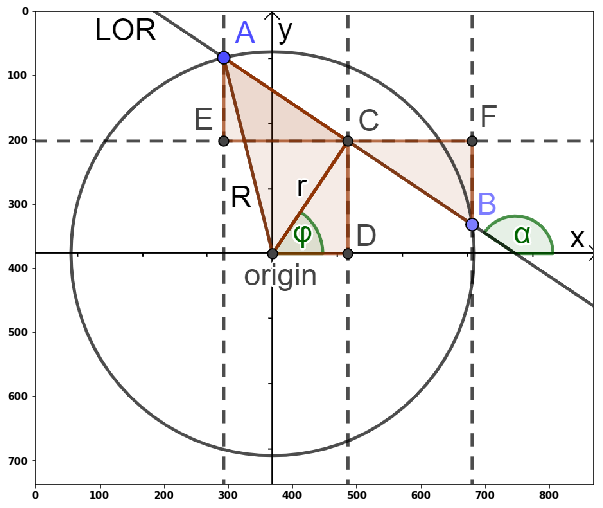

In [7]:
#construction of position as reference
%matplotlib inline
img_path = r"C:/Users/petct/Desktop/Hugo/LOR2Dgeometry.png"
img = mpimg.imread(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.show()

In [ ]:
def imageBinFromHistogramBin(histogramBin):
    """ input is a sequence [tofbin,mi,tx,ro]. return the image bin [z,y,x]. Is vectorized"""
    #origin (Siemens) position in array
    tofbin, mi,tx, robin = histogramBin
    #print("tofbin", tofbin)
    #print("mi", mi)
    #print("tx", tx)
    #print("ro", ro)
    ro = robin - Utility.NUMBER_OF_PROJECTIONS//2
    
    ao = Utility.AXIAL_INDEX_MAP[mi]
    seg = Utility.SEGMENT_OFFSET_MAP[Utility.SEGMENT_INDEX_MAP[mi]]
    tof = np.zeros(np.size(seg), dtype=int)
    prompts = tofbin != len(Utility.TOF_OFFSET_MAP)
    delays = prompts == False
    
    tof[prompts] = Utility.TOF_OFFSET_MAP[tofbin[prompts]]
    tof[delays] = 1 + len(Utility.TOF_OFFSET_MAP)//2 
    #print("tof", tof)
    #print("unique tof", np.unique(tof))
    #print("unique seg", np.unique(seg))
    #print("unique ro", np.unique(ro))

    #constants
    origin_array = [0, Utility.IMAGE_SHAPE[1]//2, Utility.IMAGE_SHAPE[2]//2]
    #header file info, relating bins and mm
    #norm /sino / LM file hdr
    mm_per_pixel = np.array([2.027, 4.07283, 4.07283]) 
    mm_per_ro = 2.005
    # header file
    # "transaxial FOV diameter (cm) :=70.4"
    # mCT brochure / Jakoby et al
    # "the industry’s only 78 cm bore ""

    # e7tools vg60 gm_check 1104 (model 1104)
    # ...
    # crystalRadius()=42.76cm
    # ... 
    # sinogramDepthOfInteraction()=0.67cm
    # LORDepthOfInteraction()=0.96cm
    # ...
    #  tofOffset()=0.039ns
    # tofBinSize()=0.3125ns
    # ... 

    #cylinder_radius_mm = 78*10/2
    crystalRadius_mm = 42.76*10
    LORDepthOfInteraction_mm= 9.6
    sinogramDepthOfInteraction_mm=6.7
    cylinderRadius_mm = crystalRadius_mm+LORDepthOfInteraction_mm
    cylinderRadius_mm_square = np.power(cylinderRadius_mm, 2)
    tof_bin_time_s = 312.5*1e-12
    tof_offset_s = tof_bin_time_s / 8.0
    c_lightspeed_m_per_s = 299792458

    #calculate in mm space first, then convert to pixels
    # assume Siemens coordinates, then translate by origin to array
    #decide directions R,S,T from angles
    #then no worries about ro == 0
    #As R,S are 2D and transaxial, only T changes between pixel space and mm space
    #tof bin requires mm space
    Rx = Utility.TX_ANGLE_TO_RX[tx]
    Ry = Utility.TX_ANGLE_TO_RY[tx]
    if np.any(Ry < 0):
        print("invalid R direction, y < 0")
    
    # R(y) and S(x) are always positive
    # R(x) and S(y) have opposite signs
    Sx = Ry
    Sy = -1*Rx
    if np.any(Sx < 0):
        print("invalid S direction, x < 0")
    
    S_direction = np.array([Sy, Sx])
    #print("S\n", S_direction)
    #print("ro*Rx", ro*Rx)
    C_position_mm = np.array([ao*mm_per_pixel[0],
                             ro*Ry*mm_per_ro,
                             ro*Rx*mm_per_ro])
    #print("C_position_mm\n", C_position_mm)
    ro_mm_square = np.power(ro*mm_per_ro, 2)
    #print("triangle_squares", triangle_squares)
    CA_mm_square = cylinderRadius_mm_square-ro_mm_square
    if (np.any(CA_mm_square < 0)):
        print("negative CA_mm_square")
        print("cylinderRadius_mm_square", cylinderRadius_mm_square)
        print("ro_mm_square", ro_mm_square)
    
    CA_mm = np.sqrt(CA_mm_square)
    #print("CA_mm", CA_mm)
    rd_mm = seg*Utility.AXIAL_COMPRESSION*mm_per_pixel[0]
    # A,B not explicitly used, but useful for eventual correction
    #A_position_mm = np.array(C_position_mm)
    #A_position_mm[1:] -= CA_mm*S_direction
    #B_position_mm = C_position_mm
    #B_position_mm[1:] += CA_mm*S_direction
    #A_position_mm[0] -= rd_mm  
    #B_position_mm[0] += rd_mm
    
    # assume A,B positions are distinct
    T_direction_mm = np.zeros_like(C_position_mm)
    T_direction_mm[1:] = CA_mm*S_direction
    T_direction_mm[0] = rd_mm
    #print("T_direction\n", T_direction_mm)
    #normalize T
    norms = np.linalg.norm(T_direction_mm, axis=0)
    #print("norms", norms)
    if np.any(norms == 0):
        print("invaliv normalization 0")
    T_direction_mm = T_direction_mm / norms
    if np.any(T_direction_mm[2] < 0):
        print("invalid T direction, x < 0")
    
    #print("normalized T\n", T_direction_mm[:,0])

    #determine position A,B by z0, C, and CB,CA in figure above

    #correction factor tof_offset_s should be negative according to documentation
    t_s = tof*tof_bin_time_s 
    #t_s += tof_offset_s
    t_mm = t_s*c_lightspeed_m_per_s*1e3
    #convert T_direction (in pixel space) to direction in mm space
    t_position_mm = t_mm*T_direction_mm
    #print("unique t_mm", np.unique(t_position_mm))
    event_position_mm = t_position_mm + C_position_mm
    #print(np.shape(event_position_mm))
    origin_array = np.reshape(origin_array, newshape=(3,1))
    
    #print("origin_array", origin_array)
    #print(mm_per_pixel)
    event_img_bin = event_position_mm / np.reshape(mm_per_pixel, newshape=(3,1)) 
    event_img_bin += origin_array
    return np.array(event_img_bin, dtype=int)

In [ ]:
#test vectorization
hbin = np.array([0,0,0,0])
print(imageBinFromHistogramBin(hbin))
histoBins = np.swapaxes([hbin, hbin+1], 0, 1)
print("histobins\n", histoBins)
print("histobins shape", histoBins.shape)
imgBins = imageBinFromHistogramBin(histogramBin=histoBins)
print("image bins\n", imgBins)

In [ ]:
#read data and convert to image points
promptsImageBins = []
delaysImageBins = []
for path in LM_paths:
    with open(path, "rb") as file: # safer than fromfile(path)
        LM = np.fromfile(file, dtype=np.uint32)
    #print("LM shape", LM.shape)
    timeSlices = Utility.timeSlices(LM, timeTagsPerSlice=10000)
    #print("timeSlices len", len(timeSlices))
    ts = timeSlices[0]
    #print("timeSlices[0] shape", ts.shape)
    timeSliceEvents = Utility.events(ts)
    #print("time slice events shape", timeSliceEvents.shape)
    bDelays = Utility.bDelays(timeSliceEvents)
    
    delays = timeSliceEvents[bDelays]
    prompts = timeSliceEvents[bDelays == False]
    
    delaysHistoBins = Utility.binAddresToProjectionSpace(np.array(delays, dtype=int))
    promptsHistoBins = Utility.binAddresToProjectionSpace(np.array(prompts, dtype=int))
    
    delaysImBins = imageBinFromHistogramBin(delaysHistoBins)
    promptsImBins = imageBinFromHistogramBin(promptsHistoBins)
    #print("delays shape", delaysImBins.shape) 
    delaysImageBins.append(delaysImBins)
    #print("prompts shape", promptsImBins.shape)
    promptsImageBins.append(promptsImBins)
    print(len(promptsImageBins))

In [ ]:
# add images to histo_image
def bValidImageBin(points3D):
    """ vectorized function to check if bins are valid for image array ( not less than 0 or too large )"""
    criterions = np.zeros((2*3,np.size(points3D[0])), dtype=np.bool)
    for k in range(3):
        criterions[2*k] = points3D[k] > -1
        criterions[2*k+1] = points3D[k] < Utility.IMAGE_SHAPE[k]
    return np.all(criterions, axis=0)

histoImages = []
for gate in promptsImageBins:
    histo = np.zeros(Utility.IMAGE_SHAPE)
    temp = gate[:, bValidImageBin(gate)]

    print("gate shape", gate.shape)
    print("valid shape", temp.shape)
    
    validPoints = temp
    print(np.sum(validPoints))
    np.add.at(histo, tuple(validPoints), 1)
    histoImages.append(histo)

In [ ]:
A = np.array([[1,4], [2,3]])
print(tuple(A))

In [ ]:
print(Utility.IMAGE_SHAPE)

In [ ]:
print(np.sum(histoImages[0]))

In [ ]:
titles = []
for s in sino_paths:
    fileName = s.split('/')[-1]
    gateNumber = fileName.split('-')[2]
    titles.append("histo image of " + phantom_str + " gate " + str(gateNumber))

%matplotlib inline
Utility.interactImages(histoImages,titles=titles, subplotShape=(1,2), figsize=(10,10))

In [ ]:
%matplotlib inline
Utility.interactImages(recons, titles=reconTitles, subplotShape=(1,2), figsize=(10,10))

In [ ]:
histoImageCOM = []
for k in range(2):
    print("center of mass of " + titles[k])
    com = Utility.CenterOfMassMultiplication(histoImages[k])
    print(Utility.IMAGE_DIMENSION_TITLES)
    print(com)

In [ ]:
#get center of mass of reconstruction for comparison
recons = []
reconCOM = []
reconTitles = []
for path in recon_paths:
    folderName = path.split('/')[-2]
    gateNumber = folderName.split('_')[-1]
    title = "recon. of " + phantom_str + " gate " + str(gateNumber)
    reconTitles.append(title)
    phantom_dicom = Utility.load_scan(path)
    phantom_pixels = Utility.get_pixels_hu(phantom_dicom)
    recons.append(phantom_pixels)
    com = Utility.CenterOfMassMultiplication(phantom_pixels)
    print(title)
    print(Utility.IMAGE_DIMENSION_TITLES)
    print(com)

In [ ]:
promptsImageBinMean = []
for k,pib in enumerate(promptsImageBins):
    #print(pib.shape)
    pibm = np.mean(pib, axis=1)
    print("center of mass of all prompts of ", titles[k])
    print(pibm)
    promptsImageBinMean.append(pibm)

In [ ]:
%matplotlib inline
compare = np.append(recons, histoImages)
compareTitles = np.append(titles, reconTitles)
Utility.interactImages(compare, titles=compareTitles, subplotShape=(2,2), figsize=(10,10))

In [ ]:
#look at histoimage image
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(5,5))
ax = fig.gca(projection='3d')
gateNumber = 0
border = 100
ax.set_xlim(-border, 109+border)
ax.set_ylim(-border, 200+border)
ax.set_zlim(-border, 200+border)
ax.set_xlabel(Utility.IMAGE_DIMENSION_TITLES[0])
ax.set_ylabel(Utility.IMAGE_DIMENSION_TITLES[1])
ax.set_zlabel(Utility.IMAGE_DIMENSION_TITLES[2])

count = 1000
plt.plot(promptsImageBins[gateNumber][0,:count], 
         promptsImageBins[gateNumber][1,:count], 
         promptsImageBins[gateNumber][2,:count], 'bo')
plt.plot(delaysImageBins[gateNumber][0,:count], 
         delaysImageBins[gateNumber][1,:count], 
         delaysImageBins[gateNumber][2,:count], 'ro')
plt.legend(["prompts", "delays"])

plt.show()
%matplotlib notebook

In [ ]:
print(np.shape(promptsImageBins[1]))

In [ ]:
print(Utility.binAddresToProjectionSpace.__doc__)